In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import waveletFunctions as wlf
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy.io.idl import readsav
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.optimize import curve_fit
from sympy import *
import seaborn as sns
import pandas as pd

## Analysis of synthetic signals

In [2]:
# parameters
dt = 1
N = 10**3
t = np.array([i*dt for i in range(N)])

In [3]:
def sinusoidal(A,f,t):
    return A*np.sin(2*np.pi*f*t)

In [4]:
def manual_FT(s,dt=1):
    Nmax = len(s)
    T = dt*Nmax
    
    ans = np.zeros([Nmax],dtype=complex)
    for i in range(Nmax):
        ans[i] = (1/Nmax) * np.sum([s[l]*np.exp(-(2j)*np.pi*i*l/Nmax) for l in range(Nmax)])

    
    return ans
 
    
def manual_PSD(signal,dt=1):
    u = manual_FT(signal,dt)
    Nmax = len(u)
    T = dt*Nmax
    n2 = int(Nmax/2)
    
    s = 2*T*np.abs(u[:n2])**2
    freq = [n/T for n in range(n2)]
    return freq,s
    
    
    

Text(0.5, 1.0, 'Spectral Energy Density')

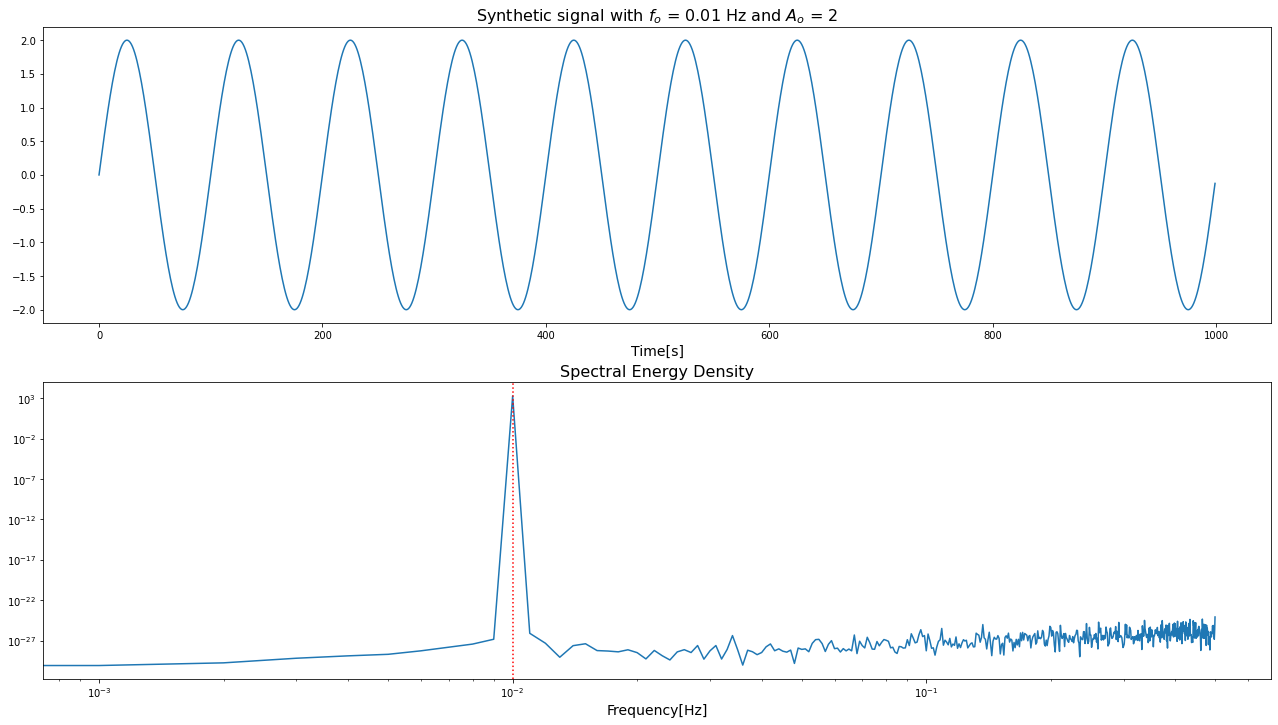

In [5]:
f0 = 0.01
A0 = 2
y= sinusoidal(A0,f0,t) # plotting an exqmple of low f
freq,psd = manual_PSD(y)

plt.figure(figsize=(22,12))
plt.subplot(2,1,1)
plt.title("Synthetic signal with $f_o$ = {:.2f} Hz and $A_o$ = {}".format(f0,A0),fontsize=16)
plt.plot(t,y)
plt.xlabel("Time[s]",fontsize=14)
plt.subplot(2,1,2)
plt.plot(freq,psd)
plt.axvline(f0,linestyle=":",c="r")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency[Hz]",fontsize=14)
plt.title("Spectral Energy Density".format(f0),fontsize=16)

Is safe to asume that the spectrum energy density integral is reduced to a $\delta (f)$ function centered in $f_o$  therefore,
$$\sum_f PSD \sim max(PSD)*1$$
and from pqrseval theorem we know
$$\sum_f PSD = 2 \delta t \sum_t Signal$$
defining a new quantity R we can measure how accurate is parseval theorem
$$R = 2\delta t \frac{\sum_t Signal}{max(PSD)}$$
The more accurate is Parseval theorem, the closer R is to 1. From [solving](https://www.wolframalpha.com/input/?i=integral+from++0+to+1000+of+2*sin%5E2%280.04+pi+x%29+dx+) analytically the integral of squared signal over time, the value of $\sum_t Signal$ for such freauency and amplitude is calculateda round 1000. 

In [6]:
np.max(psd)

2000.0

In [7]:
print("R = ",1000.*(2*dt)/np.max(psd))

R =  1.0


As expected, the peak is in the assigned frequency while the other parts of the spectra have a PSD of the order <$10^{-23}$

In [8]:
# amplitude and frequency constants for sin functions
A0 = 2 
A1 = 0.8
f0 = 0.01
f1 = 0.08

# building y1 and y2
y_1 = sinusoidal(A0,f0,t)+sinusoidal(A1,f1,t)
y_2 = sinusoidal(A0,f0,t)
y_2[int(len(t)/2):] = sinusoidal(A1,f1,t[int(len(t)/2):])

#obtaining PSD
freq1,psd1 = manual_PSD(y_1)
freq2,psd2 = manual_PSD(y_2)

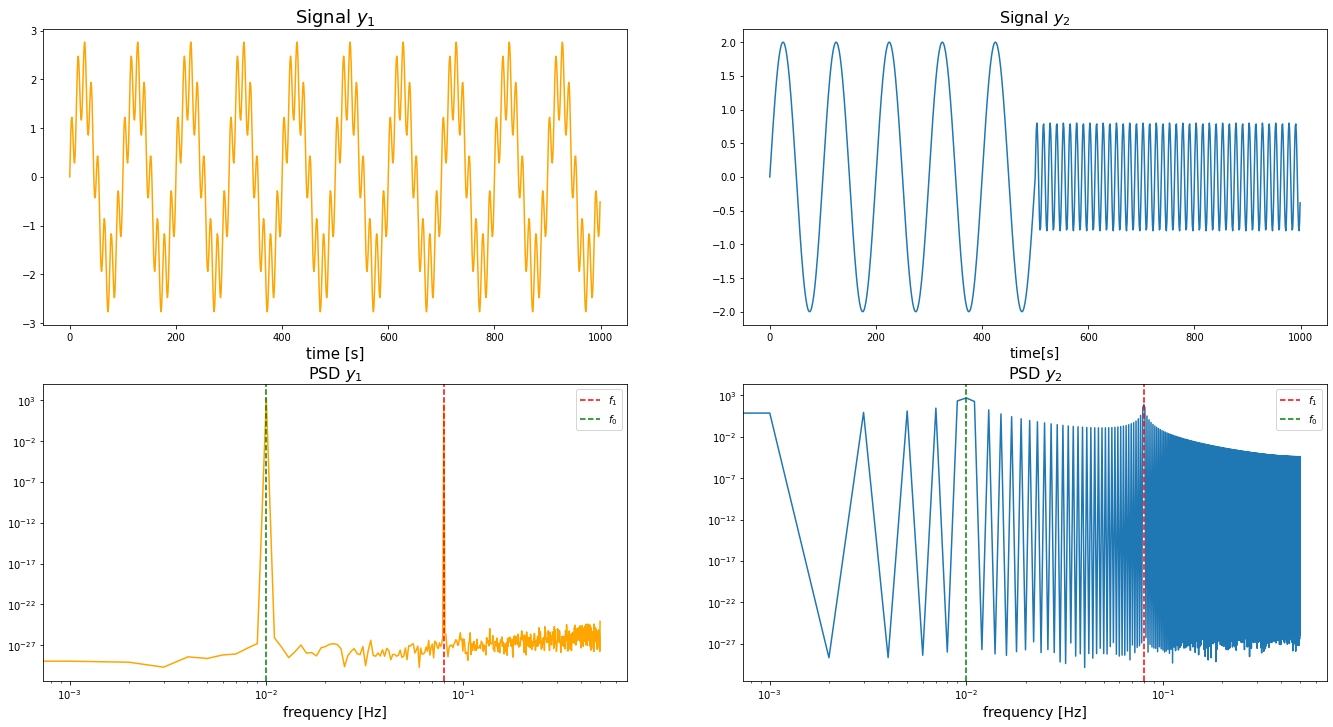

In [9]:


plt.figure(figsize=(23,12))

plt.subplot(2,2,1)
plt.title("Signal $y_1$",fontsize=18)
plt.plot(t,y_1,c="orange")
plt.xlabel("time [s]",fontsize=15)


#plt.subplot(3,2,3)
#plt.title("Spectral Energy Density Y1",fontsize=18)
#plt.plot(freq1,psd1,c="orange")
#plt.xlabel("frequency",fontsize=15)
#plt.xscale("log")


plt.subplot(2,2,2)
plt.title("Signal $y_2$",fontsize=16)
plt.plot(t,y_2)
plt.xlabel("time[s]",fontsize=14)

#plt.subplot(3,2,4)
#plt.title("Spectral Energy Density Y2",fontsize=16)
#plt.plot(freq2,psd2)
#plt.xlabel("frequency",fontsize=14)
#plt.xscale("log")

plt.subplot(2,2,3)
plt.title("PSD $y_1$",fontsize=16)
plt.plot(freq1,psd1,c="orange")
plt.xlabel("frequency [Hz]",fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.axvline(f1,linestyle="--",c="r",label="$f_1$")
plt.axvline(f0,linestyle="--",c="g",label="$f_0$")
plt.legend()

plt.subplot(2,2,4)
plt.title("PSD $y_2$",fontsize=16)
plt.plot(freq2,psd2)
plt.xlabel("frequency [Hz]",fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.axvline(f1,linestyle="--",c="r",label="$f_1$")
plt.axvline(f0,linestyle="--",c="g",label="$f_0$")
plt.legend()


## wavelet transformation

### For Signal Y1

/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


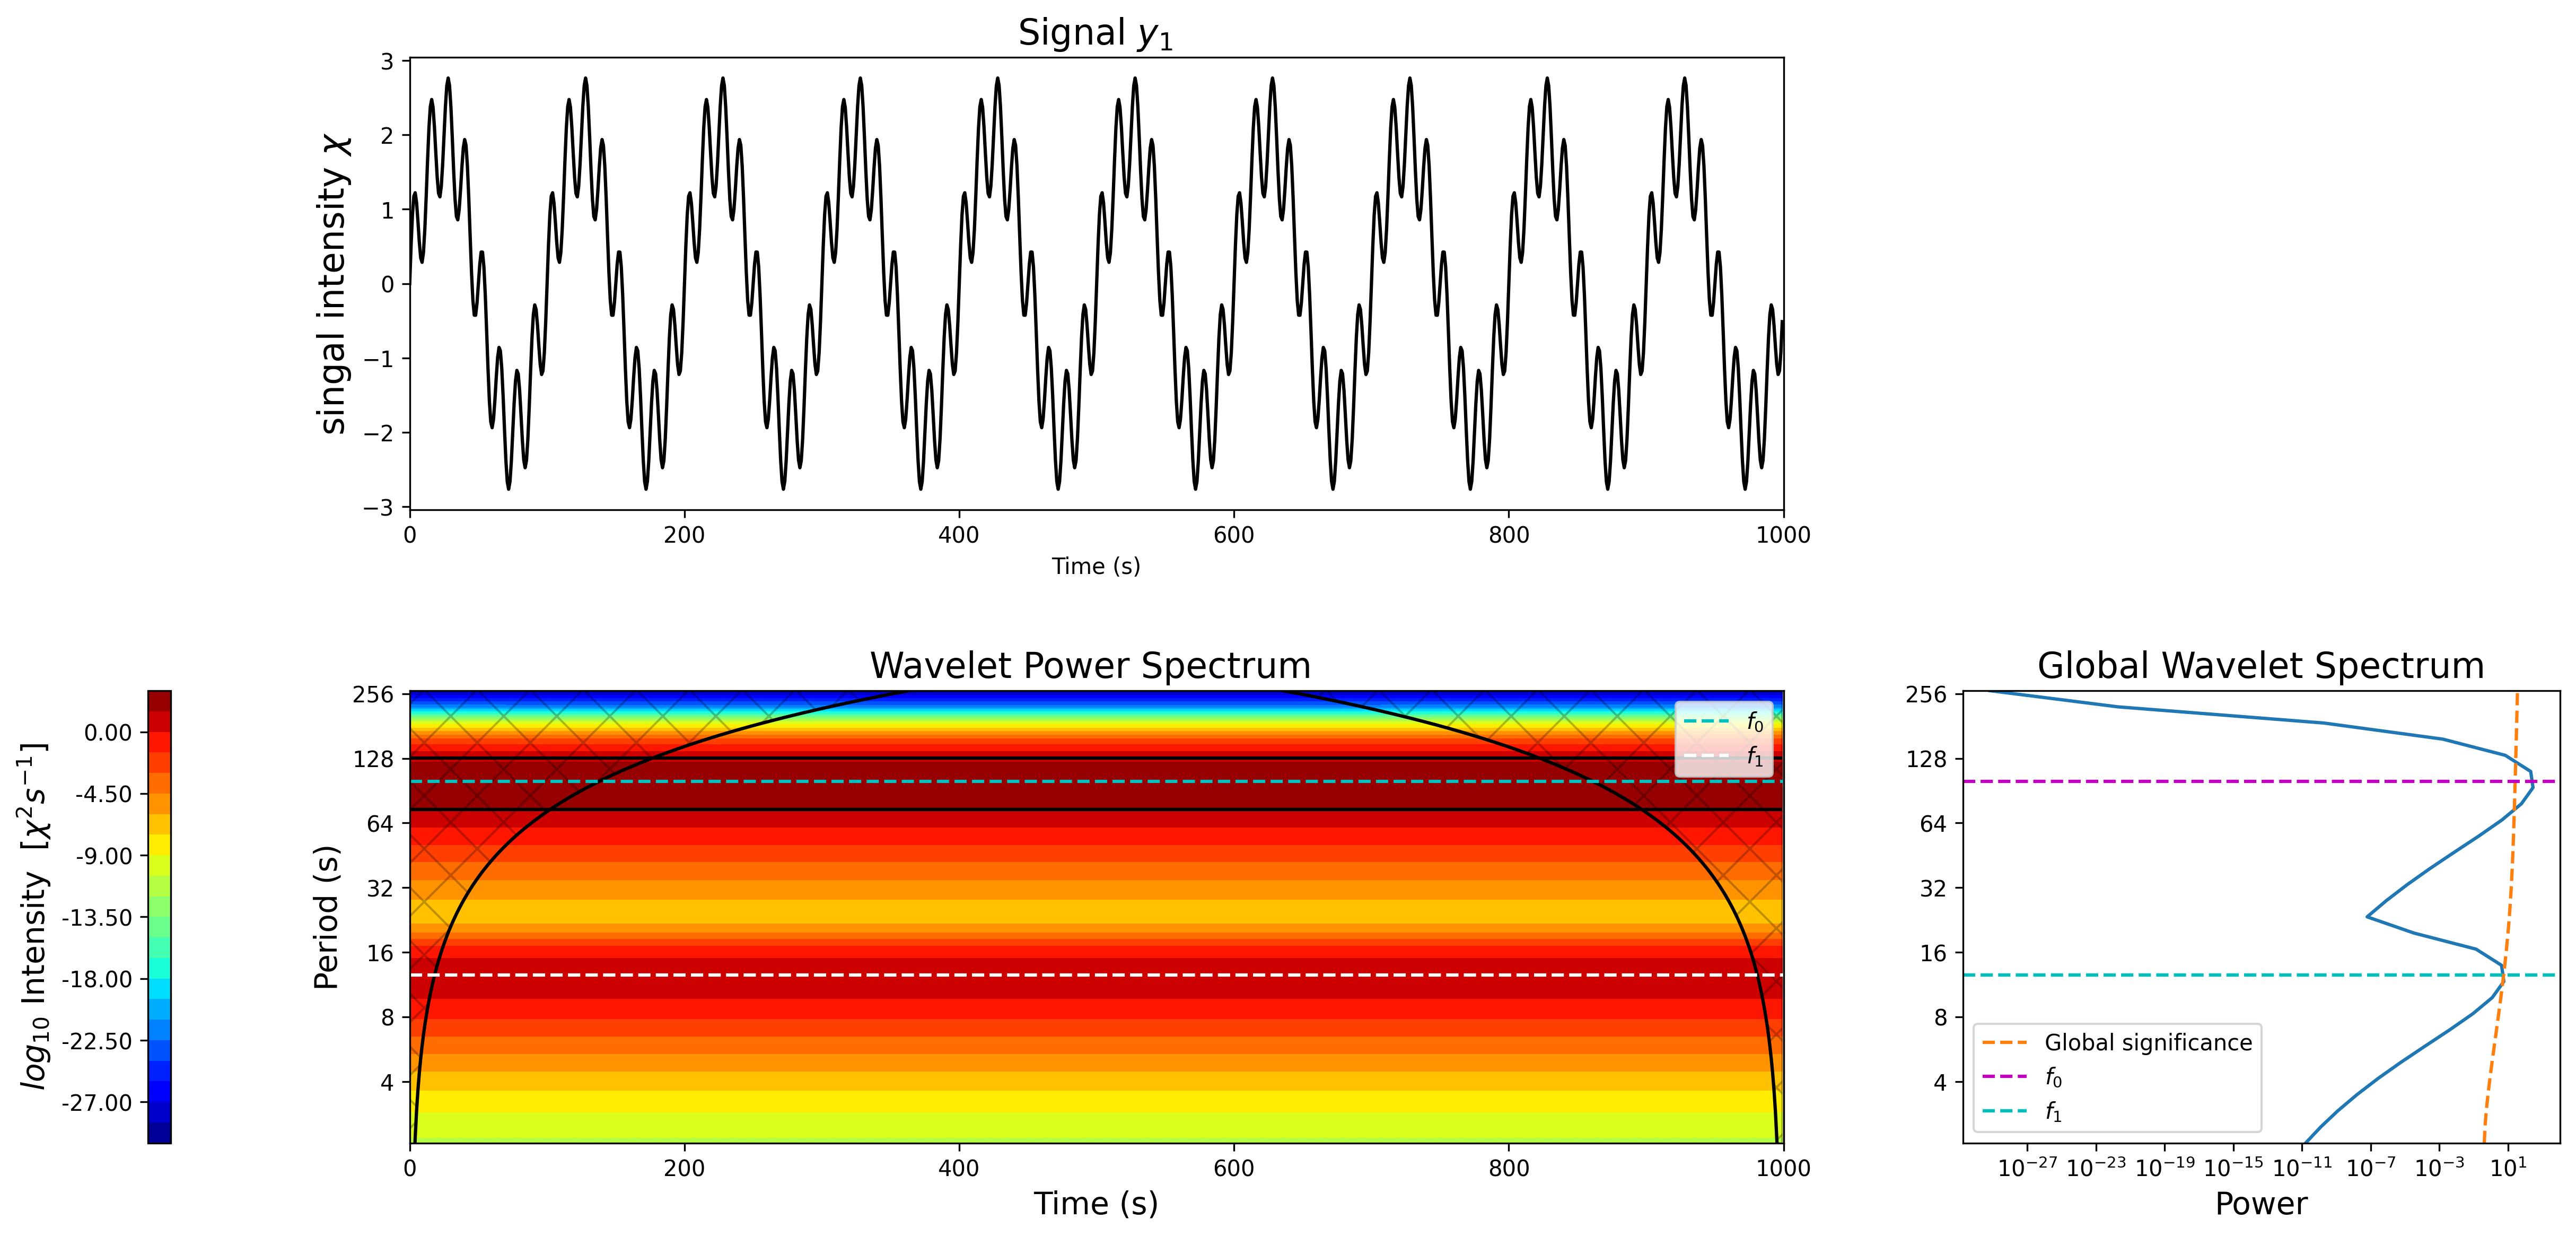

In [10]:
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array
variance = np.std(y_1, ddof=1)**2
xlim = ([0, len(y_1)])  # plotting range
pad = 0  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 =  2*dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'


# Wavelet transform:
wave, period, scale, coi = wlf.wavelet(y_1, dt, pad=pad, dj=dj, s0=s0, J1=j1, mother=mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / len(y_1))  # time-average over all times

# Significance levels:
signif = wlf.wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(y_1))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant


# Global wavelet spectrum & significance levels:
dof = len(y_1) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)





# PLOTTING
fig = plt.figure(figsize=(23, 12),dpi=300)
gs = GridSpec(3, 4, hspace=0.4, wspace=0.3)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 1:3])
plt.plot(t, y_1, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (s)')
plt.title('Signal $y_1$ ',fontsize=16)
plt.ylabel('singal intensity $\chi$',fontsize=16)
#plt.title('a) NINO3 Sea Surface Temperature (seasonal)')
# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)


plt3 = plt.subplot(gs[1, 1:3])
#levels = [0,0.1,0.5,1,2,5,10,40]
# *** or use 'contour'
CS = plt.contourf(t, period,np.log10(power), 30)
im = plt.contourf(CS,cmap="jet")
   # colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Period (s)',fontsize=14)
plt.title('Wavelet Power Spectrum ',fontsize=16)
plt.xlim(xlim[:])
#plt.axhline(1/f0,c="r",linestyle="--")
#plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(t, coi, 'k')
plt.axhline(1/f0,c="c",linestyle="--",label="$f_0$")
plt.axhline(1/f1,c="w",linestyle="--",label="$f_1$")
plt.legend()

# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
#plt3.invert_yaxis()
# set up the size and location of the colorbar
#position=fig.add_axes([0.5,0.36,0.2,0.01])
#plt.colorbar(im, orientation='vertical',location="left", fraction=0.01, pad=0.5)

#plt.subplots_adjust(right=0.7, top=0.9)
plt5 = plt.subplot(gs[1, 0])
plt5.axis("off")
cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.1,format='%.2f')
cbar.set_label("$log_{10}$ Intensity  [$\chi^2 s^{-1}$]",fontsize=14)
#plt.subplots_adjust(right=0.9, top=0.9)


# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)

plt.plot(global_signif, period, '--',label="Global significance")
plt.xlabel('Power',fontsize=14)
plt.title('Global Wavelet Spectrum',fontsize=16)
#plt.xlim([0, 1.25 * np.max(global_ws)])

plt.axhline(1/f0,c="m",linestyle="--",label="$f_0$")
plt.axhline(1/f1,c="c",linestyle="--",label="$f_1$")
plt.legend()
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt4.set_xscale('log', base=10, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
#plt.xscale("log")

#plt4.invert_yaxis()


### For signal Y2

/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


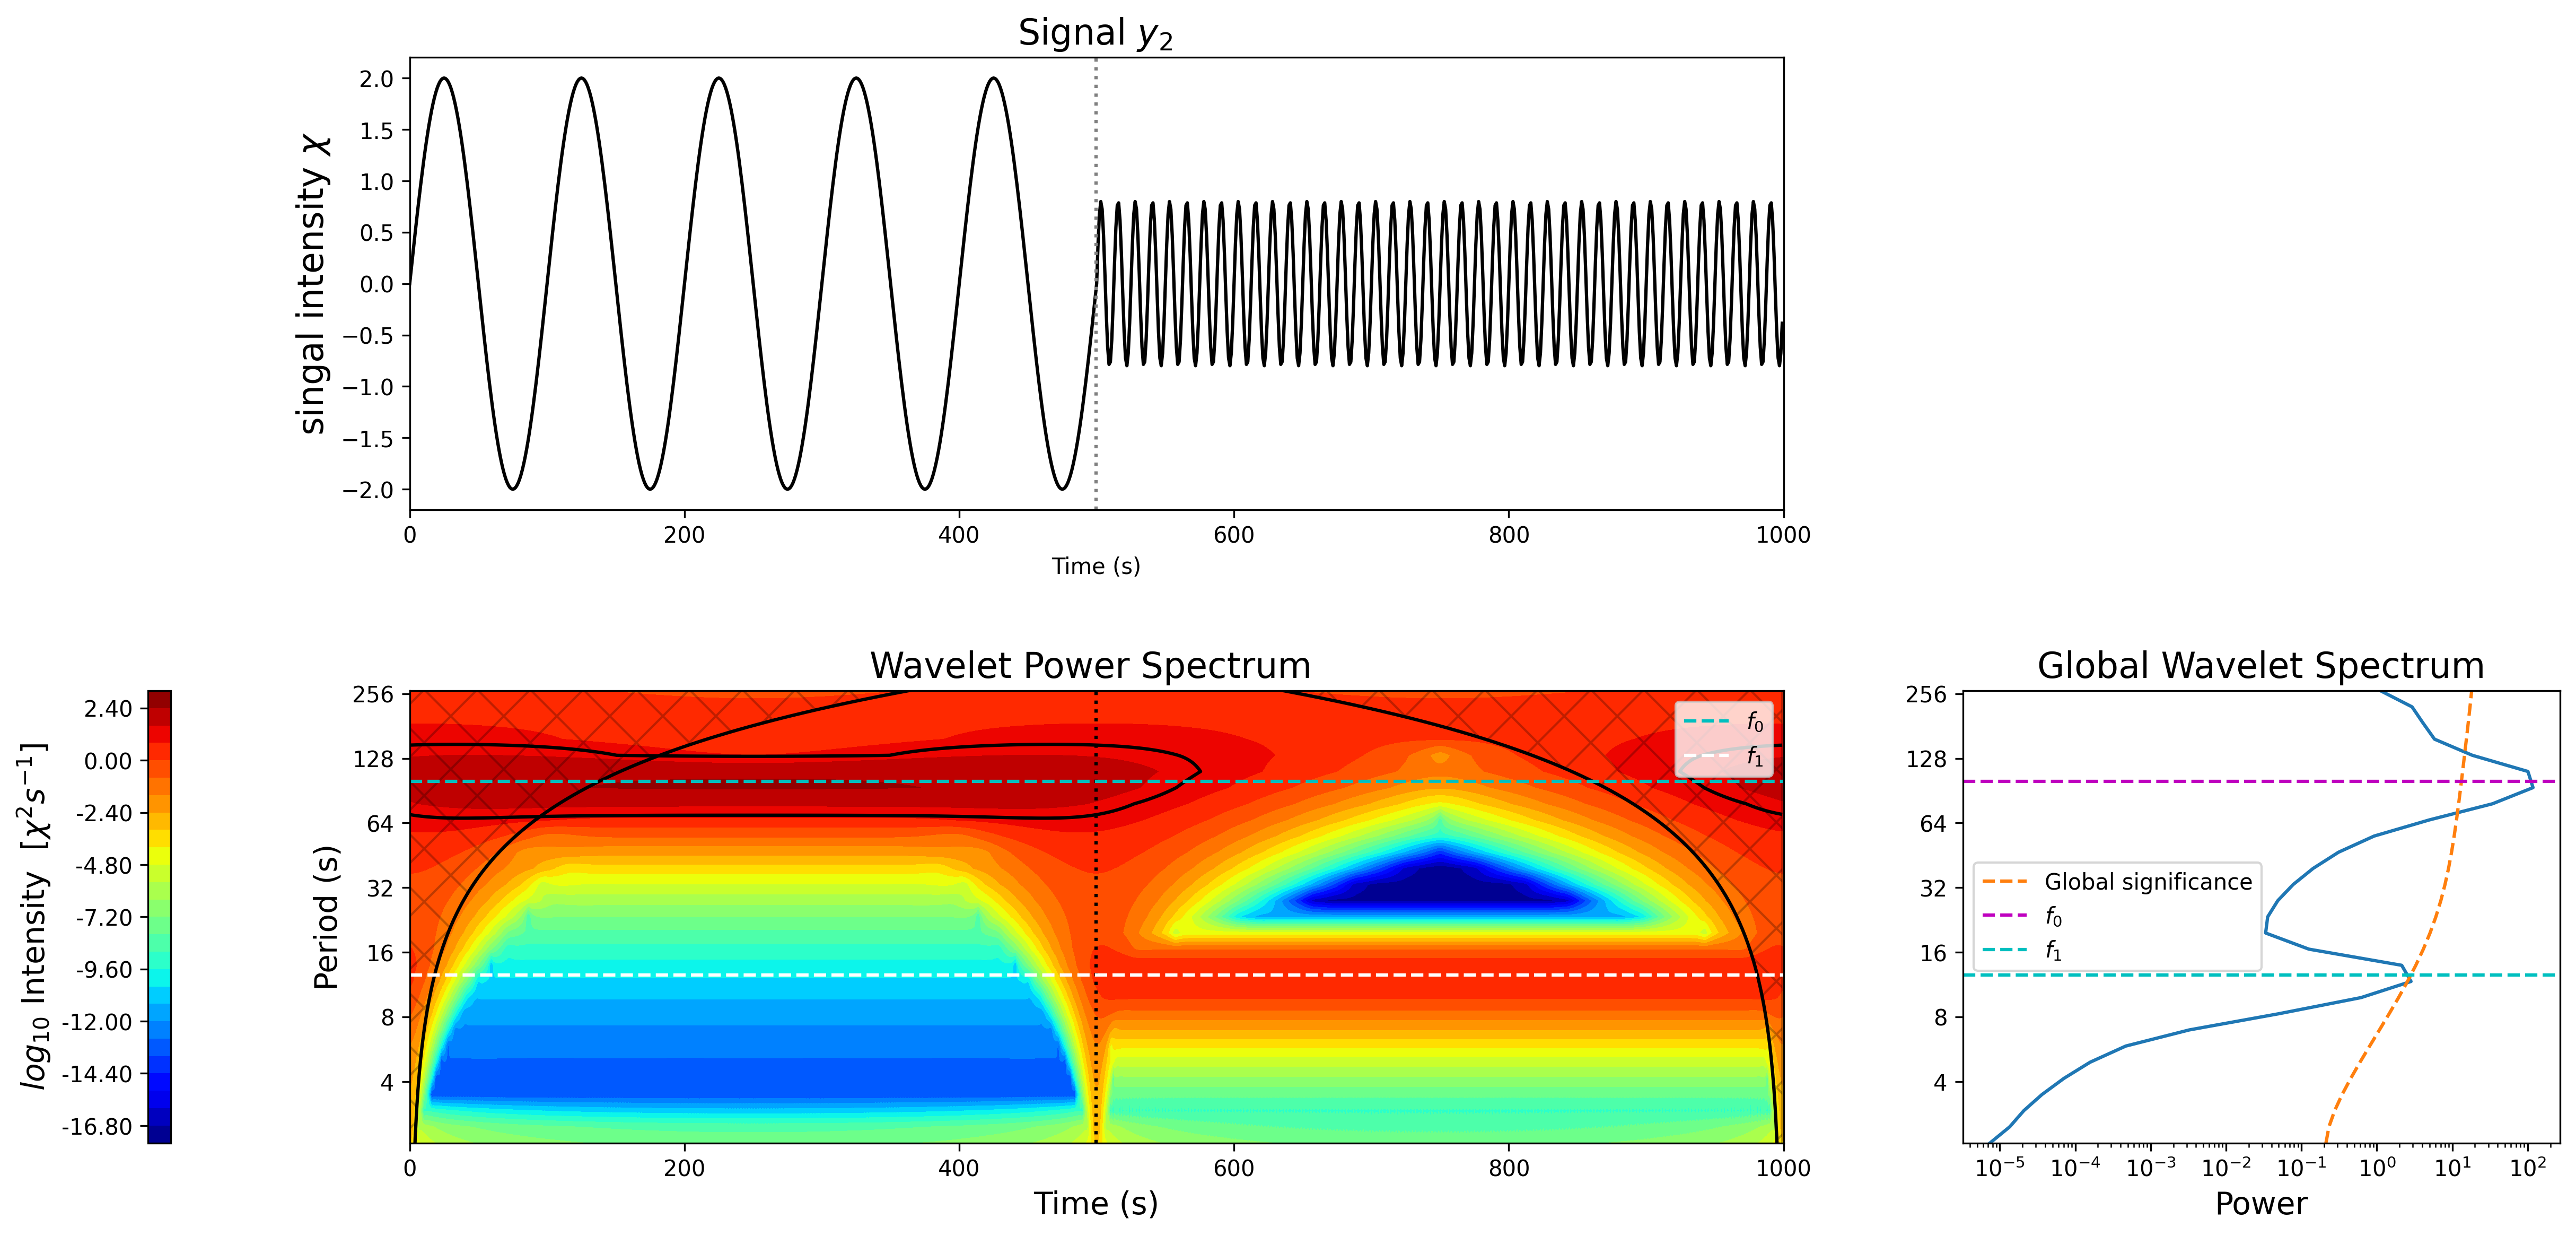

In [11]:
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array
variance = np.std(y_2, ddof=1)**2
xlim = ([0, len(y_2)])  # plotting range
pad = 0  # pad the time series with zeroes (recommended)
dj = 0.25  # this will do 4 sub-octaves per octave
s0 =  2*dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.72  # lag-1 autocorrelation for red noise background
mother = 'MORLET'


# Wavelet transform:
wave, period, scale, coi = wlf.wavelet(y_2, dt, pad=pad, dj=dj, s0=s0, J1=j1, mother=mother)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / len(y_2))  # time-average over all times

# Significance levels:
signif = wlf.wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(y_2))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant


# Global wavelet spectrum & significance levels:
dof = len(y_2) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)





# PLOTTING
fig = plt.figure(figsize=(23, 12),dpi=300)
gs = GridSpec(3, 4, hspace=0.4, wspace=0.3)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                    wspace=0, hspace=0)
plt.subplot(gs[0, 1:3])
plt.plot(t, y_2, 'k')
plt.axvline(np.max(t)/2,c="gray",linestyle=":")
plt.xlim(xlim[:])
plt.xlabel('Time (s)')
plt.title('Signal $y_2$ ',fontsize=16)
plt.ylabel('singal intensity $\chi$',fontsize=16)
#plt.title('a) NINO3 Sea Surface Temperature (seasonal)')
# --- Contour plot wavelet power spectrum
# plt3 = plt.subplot(3, 1, 2)


plt3 = plt.subplot(gs[1, 1:3])
#levels = [0,0.1,0.5,1,2,5,10,40]
# *** or use 'contour'
CS = plt.contourf(t, period,np.log10(power), 30)
im = plt.contourf(CS,cmap="jet")
   # colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Period (s)',fontsize=14)
plt.title('Wavelet Power Spectrum ',fontsize=16)
plt.xlim(xlim[:])
plt.axvline(np.max(t)/2,c="k",linestyle=":")
#plt.axhline(1/f0,c="r",linestyle="--")
#plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#00000040", hatch='x')
plt.plot(t, coi, 'k')
plt.axhline(1/f0,c="c",linestyle="--",label="$f_0$")
plt.axhline(1/f1,c="w",linestyle="--",label="$f_1$")
plt.legend()

# format y-scale
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')
#plt3.invert_yaxis()
# set up the size and location of the colorbar
#position=fig.add_axes([0.5,0.36,0.2,0.01])
#plt.colorbar(im, orientation='vertical',location="left", fraction=0.01, pad=0.5)

#plt.subplots_adjust(right=0.7, top=0.9)
plt5 = plt.subplot(gs[1, 0])
plt5.axis("off")
cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.1,format='%.2f')
cbar.set_label("$log_{10}$ Intensity  [$\chi^2 s^{-1}$]",fontsize=14)
#plt.subplots_adjust(right=0.9, top=0.9)


# --- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)

plt.plot(global_signif, period, '--',label="Global significance")
plt.xlabel('Power',fontsize=14)
plt.title('Global Wavelet Spectrum',fontsize=16)
#plt.xlim([0, 1.25 * np.max(global_ws)])

plt.axhline(1/f0,c="m",linestyle="--",label="$f_0$")
plt.axhline(1/f1,c="c",linestyle="--",label="$f_1$")
plt.legend()
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt4.set_xscale('log', base=10, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
#plt.xscale("log")

#plt4.invert_yaxis()


In [12]:
print(np.min(freq),np.max(freq),len(freq))
print(1/np.max(period),1/np.min(period),len(period))

0.0 0.499 500
0.0037813019890405902 0.48400665459719555 29


In [13]:
1/(8*np.log2(500))

0.013941892424719557

## Data File

In [14]:
data = readsav("data/mix_c1_20010331.sav")
data.keys()
data["t_sc"]=data["t_sc"]-data["t_sc"][0]
data["t_dec"] = np.array([x/3600. for x in data["t_sc"]])


data["rho"] = np.sqrt(data["bx"]**2 + data["by"]**2 + data["bz"]**2 )
data["theta"] = np.arccos(data["bz"]/data["rho"])#*180/ np.pi #to degrees #np.arctan(np.sqrt(data["bx"]**2+data["by"]**2)/data["bz"])
data["phi"] = np.arctan2(data["by"],data["bx"])#*180/np.pi#[np.arctan(data["by"][i]/data["bx"][i])  for i in range(len(data["bx"])) ]
#data["phi"] = np.cos(data["phi"])
#if data["bx"][i]>=0 else np.arctan(data["by"][i]/data["bx"][i])+np.pi

25.000004099081057


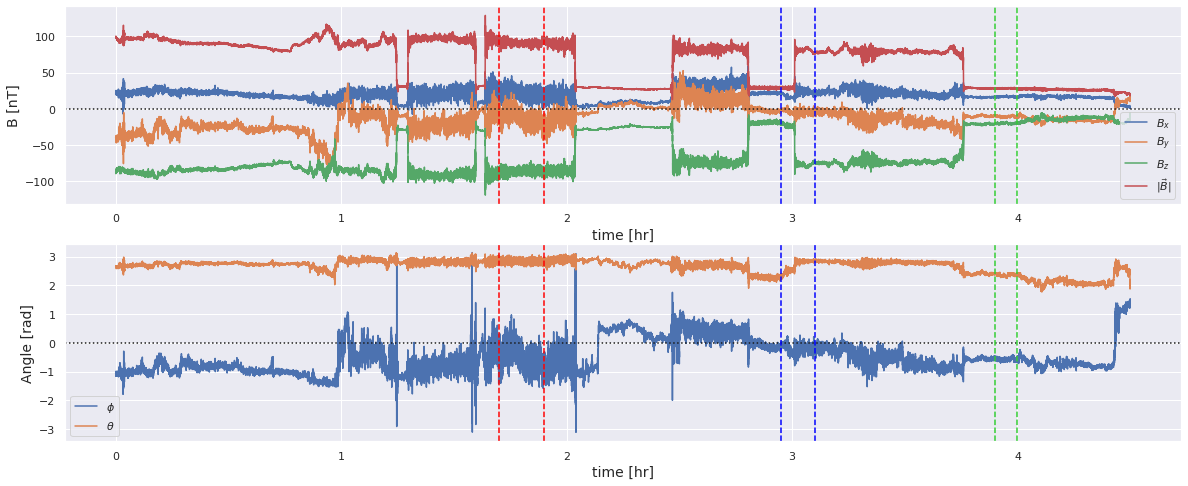

In [550]:
regions = [[1.7,1.9],[2.95,3.1],[3.9,4.0]]

s_region = regions[0] 

t_i = s_region[0]
t_f = s_region[1]

plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
#plt.title("Raw signal",fontsize=16)
plt.plot(data["t_dec"],data["bx"],label="$B_x$")
plt.plot(data["t_dec"],data["by"],label="$B_y$")
plt.plot(data["t_dec"],data["bz"],label="$B_z$")
plt.plot(data["t_dec"],data["rho"],label="|$\\vec{B}$|")
plt.axhline(0,linestyle=":",c="k")

colors = ["red","blue","limegreen"]
for rr in range(len(regions)): 
    plt.axvline(regions[rr][0] ,linestyle="--",c=colors[rr])
    plt.axvline(regions[rr][1],linestyle="--",c=colors[rr])

plt.xlabel("time [hr]",fontsize=14)
plt.ylabel("B [nT]",fontsize=14)
plt.legend(loc=4)

plt.subplot(2,1,2)
plt.plot(data["t_dec"],data["phi"],label="$\phi$")
plt.plot(data["t_dec"],data["theta"],label="$\\theta$")
plt.ylabel("Angle [rad]",fontsize=14)
plt.axhline(0,linestyle=":",c="k")
plt.xlabel("time [hr]",fontsize=14)
colors = ["red","blue","limegreen"]
for rr in range(len(regions)): 
    plt.axvline(regions[rr][0] ,linestyle="--",c=colors[rr])
    plt.axvline(regions[rr][1],linestyle="--",c=colors[rr])
plt.legend()

#print(data["t_dec"][-1])
#print(len(data["t_dec"]))
print(1/dt)

time resolution : 0.040 s
sampling frequency : 25.000 Hz


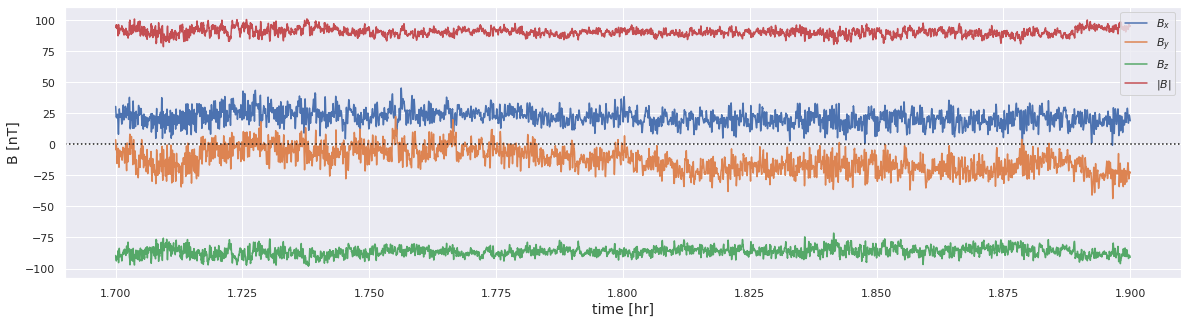

In [551]:
ii = np.logical_and(data["t_dec"]>=t_i,data["t_dec"]<=t_f)
dt = np.mean([(data["t_sc"][i]-data["t_sc"][i-1]) for i in range(1,len(data["t_sc"]))])
print("time resolution : {:.3f} s".format(dt))
print("sampling frequency : {:.3f} Hz".format(1/dt))

signal_x = data["bx"][ii]
signal_y = data["by"][ii]
signal_z = data["bz"][ii]
signal_theta = data["theta"][ii]
signal_phi = data["phi"][ii]
signal_rho = data["rho"][ii]
signal_mean = (signal_x+signal_y+signal_z)/3
signal_t = data["t_sc"][ii]
signal_td = data["t_dec"][ii]

n = len(signal_x)

plt.figure(figsize=(20,5))
plt.plot(signal_td,signal_x,label="$B_x$")
plt.plot(signal_td,signal_y,label="$B_y$")
plt.plot(signal_td,signal_z,label="$B_z$")
plt.plot(signal_td,signal_rho,label="$|B|$")
#plt.plot(signal_t,signal_mean,c="grey",label="$Mean$")
plt.axhline(0,linestyle=":",c="k")
plt.xlabel("time [hr]",fontsize=14)
plt.ylabel("B [nT]",fontsize=14)
plt.legend()

### Fourier transform

In [552]:
np.max(signal_td)#-np.min(signal_td

1.9

In [553]:
freqs = np.fft.fftfreq(n,dt)
#ii = np.logical_and(freqs>=0,freqs<500)
ii = freqs>0
freqs = 1/freqs[ii]
fourier_x = np.fft.fft(signal_x)[ii]
fourier_y = np.fft.fft(signal_y)[ii]
fourier_z = np.fft.fft(signal_z)[ii]
fourier_m = np.fft.fft(signal_rho)[ii]
fourier_theta = np.fft.fft(signal_theta)[ii]
fourier_phi = np.fft.fft(signal_phi)[ii]

Text(0, 0.5, 'Intensity |$ \\vec{B} $| [nT]')

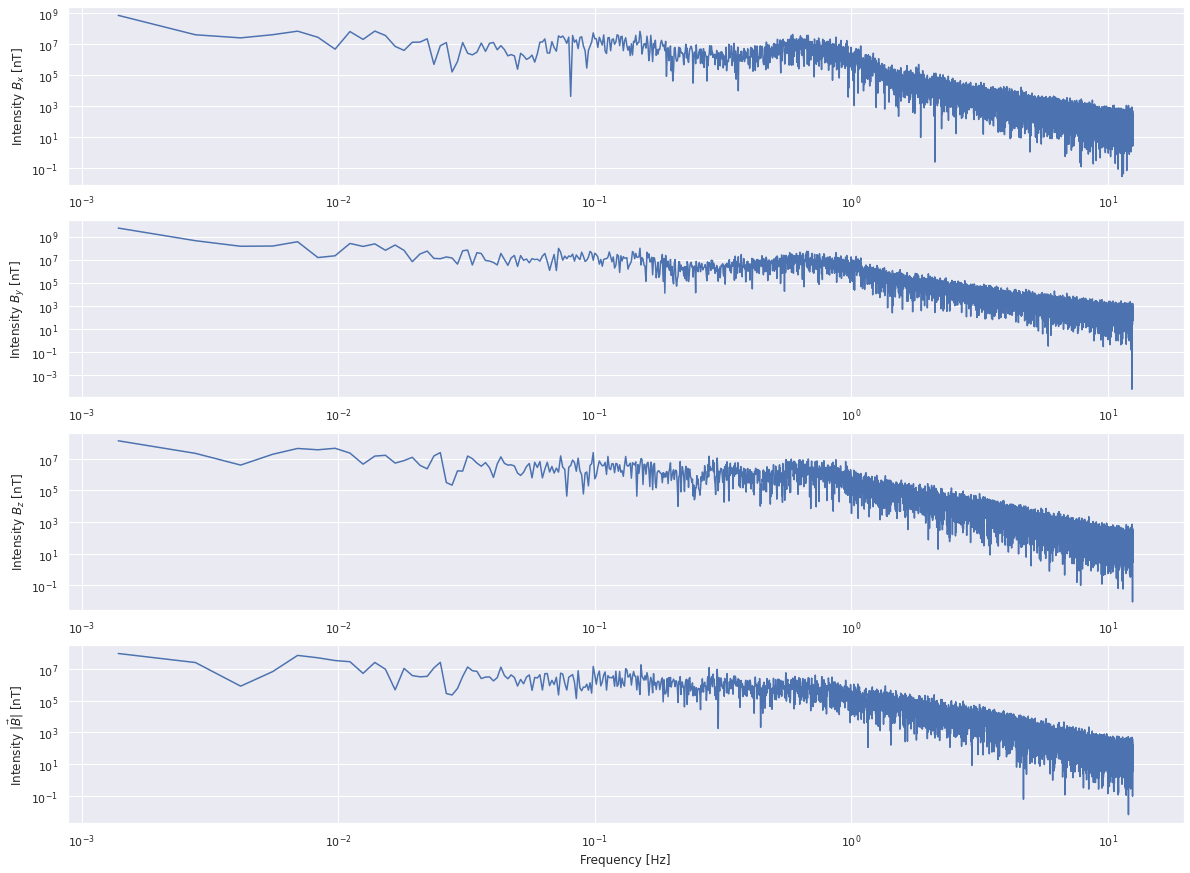

In [554]:
plt.figure(figsize=(20,15))
plt.subplot(4,1,1)
plt.plot(1/freqs,np.abs(fourier_x)**2)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Intensity $B_x$ [nT]")

plt.subplot(4,1,2)
plt.plot(1/freqs,np.abs(fourier_y)**2)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Intensity $B_y$ [nT]")

plt.subplot(4,1,3)
plt.plot(1/freqs,np.abs(fourier_z)**2)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Intensity $B_z$ [nT]")

plt.subplot(4,1,4)
plt.plot(1/freqs,np.abs(fourier_m)**2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Intensity |$ \\vec{B} $| [nT]")



### Morlet Wavelet Analysis $B_x$

Threshold in Fourier frequency stablished : freq > 10.00  Hz
Limiting frequencies for finding peaks : 9.44 Hz  to   10.56 Hz


/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/home/localuser/Documents/work_env/lib/python3.7/site-packages/ipykernel_launcher.py:175: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


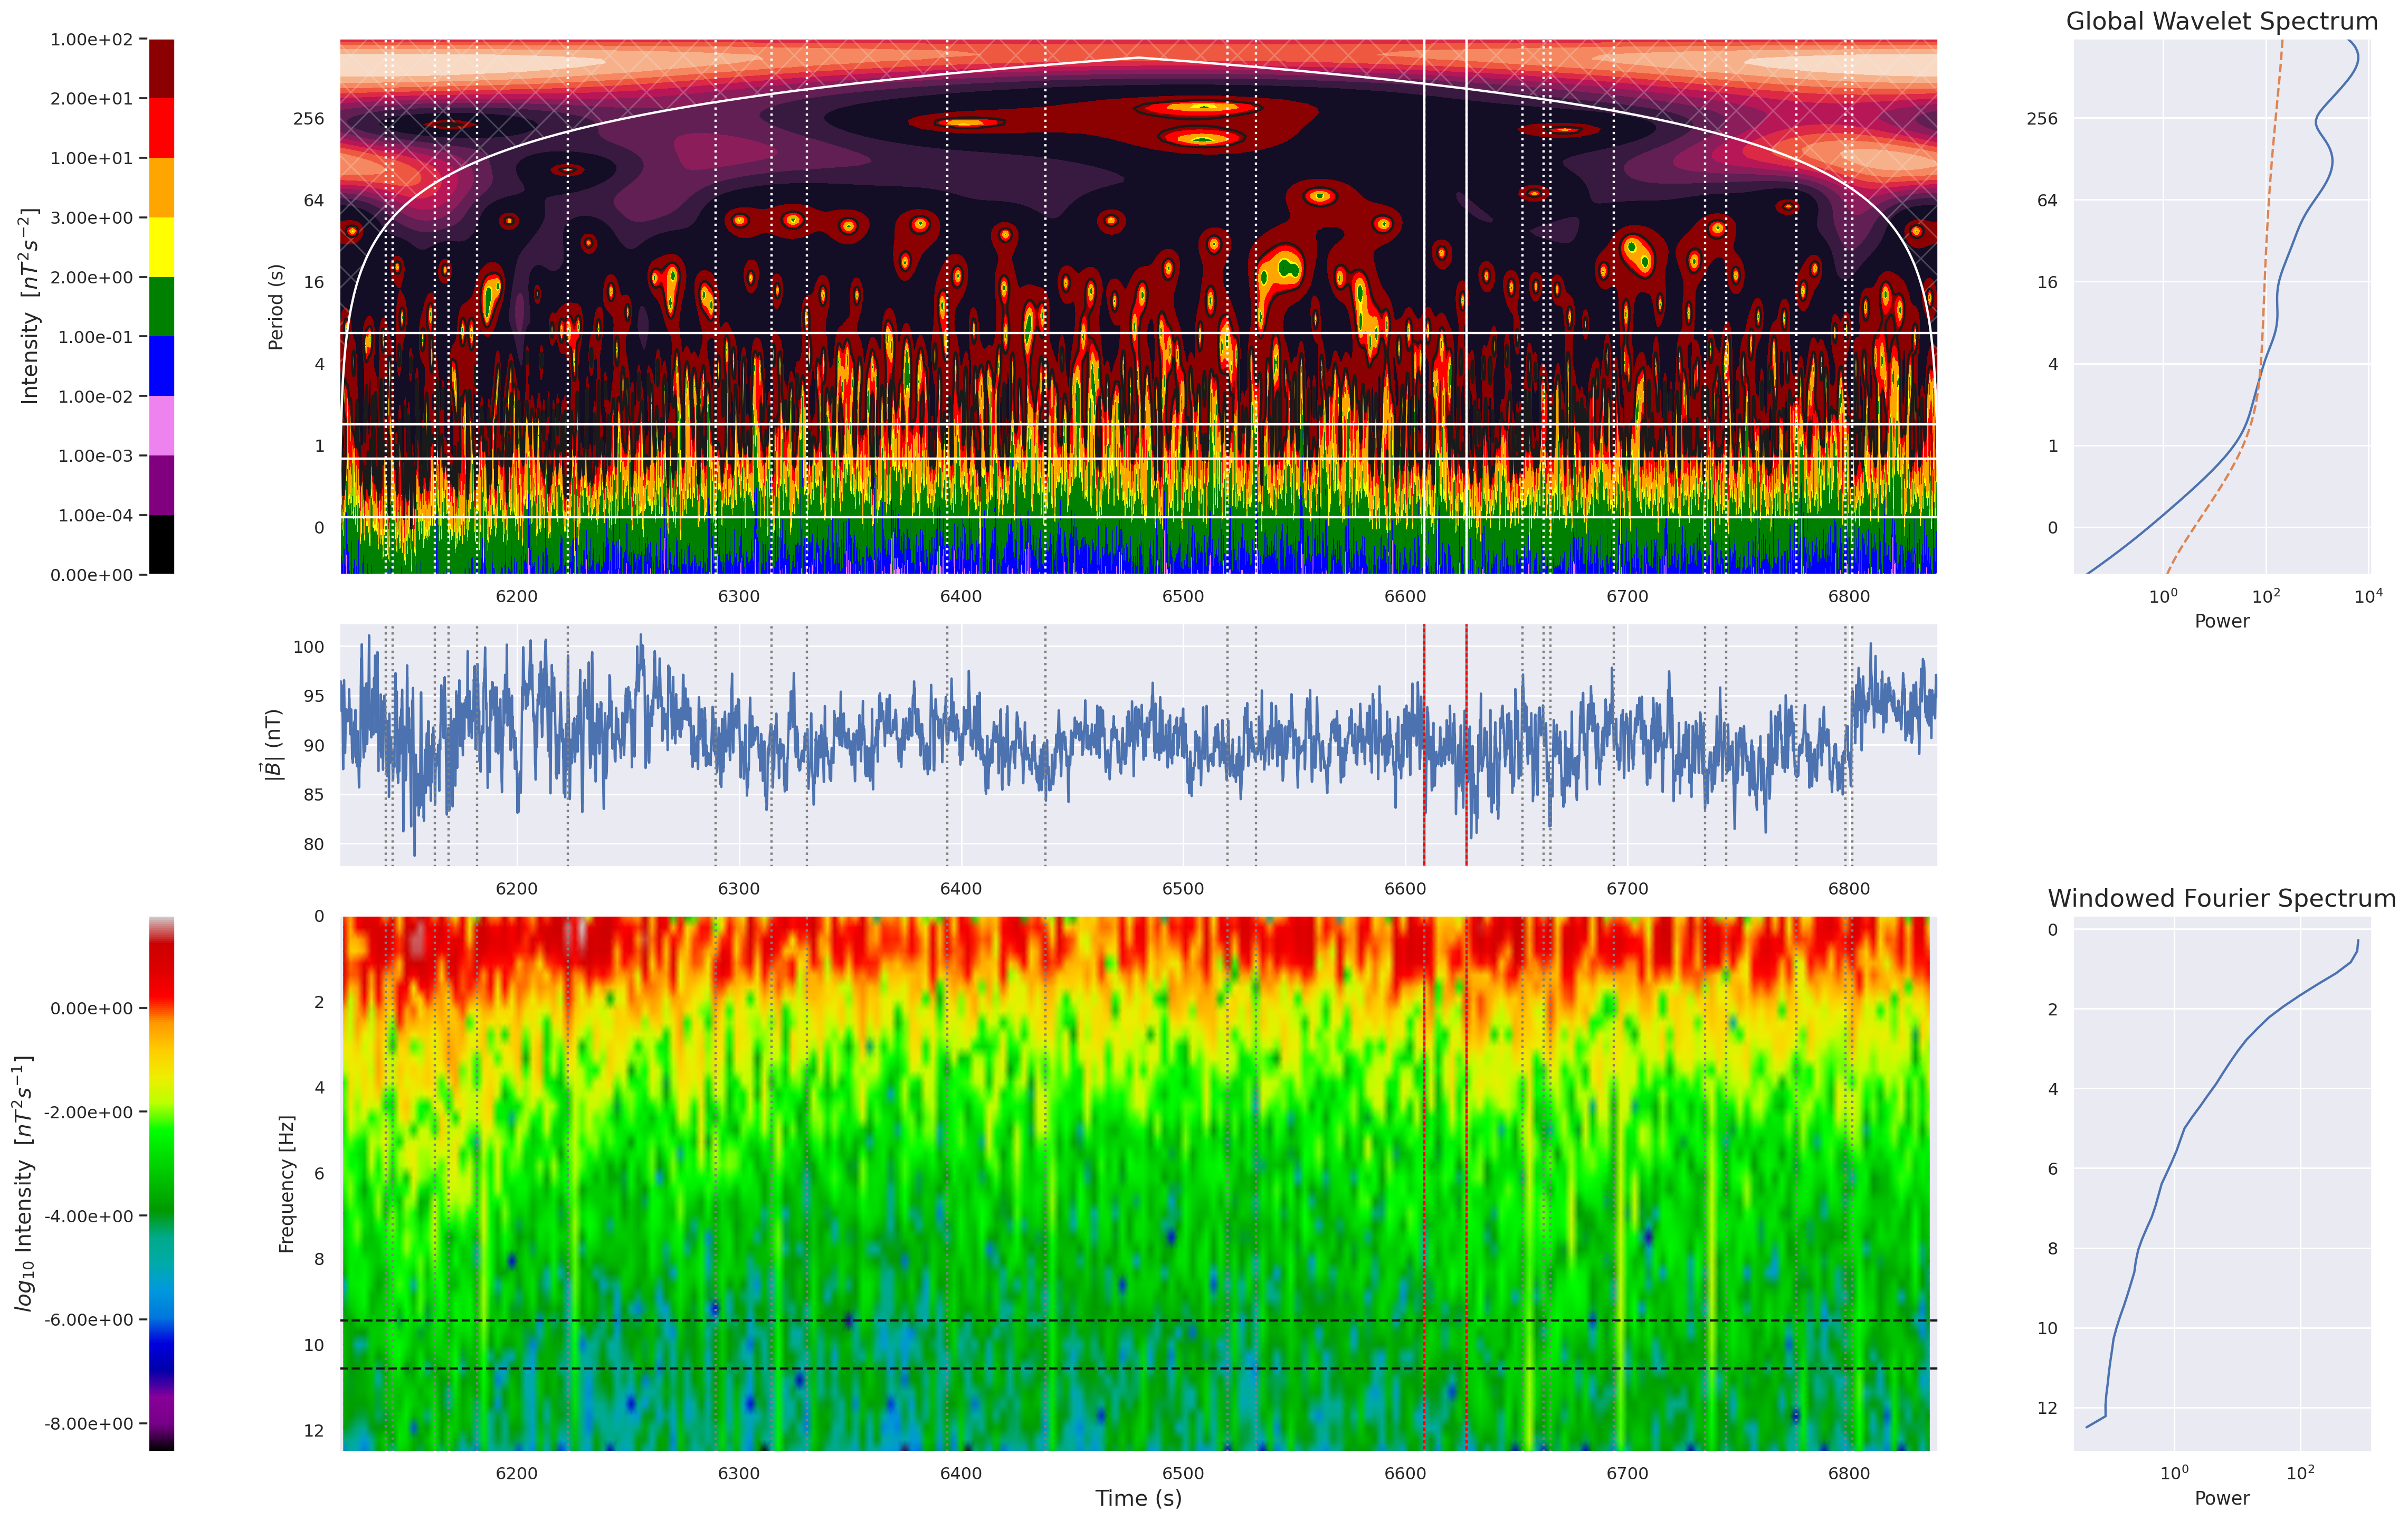

In [584]:
signalused = signal_rho
mother = 'PAUL'
wave, period, scale, coi = wlf.wavelet(signalused, dt,mother=mother,s0=2*dt,dj=0.1)
t=np.arange(len(signal_t))
power = (np.abs(wave)) ** 2
lag1 = 0.8
global_ws = (np.sum(power, axis=1) / len(signalused))  # time-average over all times
variance = np.std(signalused, ddof=1) ** 2

# Significance levels:
signif = wlf.wave_signif(([variance]),scale=scale, dt=dt,mother=mother)
# expand signif --> (J+1)x(N) array
sig95 = signif[:, np.newaxis].dot(np.ones(len(signalused))[np.newaxis, :])
sig95 = power / sig95  # where ratio > 1, power is significant
# Global wavelet spectrum & significance levels:
dof = len(signalused) - scale  # the -scale corrects for padding at edges
global_signif = wlf.wave_signif(variance, dt=dt, scale=scale, sigtest=1,lag1=lag1, dof=dof, mother=mother)


#FOURIER

plotall = True

resol = 0.005 # proportion of the length of the pieces in time to total length of signal (spectrogram)

# reviewing the lower part of the spectrogram to catch the lines without the noise in the top (low freqs)
thr = 0.8

# to find peaks,I look for abrupt chqnges in the slope of the sinal
slope_th = 0.0025 # if dSt(derivative of cumulative spectrum) changes more than this, creatr splitline

wndw = signal.get_window("flattop",int(resol*len(signal_t)))
f, t, Sxx = signal.spectrogram(signalused,1/dt,window=wndw)

# FINDING PERTURBATIONS


print("Threshold in Fourier frequency stablished : freq > {:.2f}  Hz".format(f[int(Sxx.shape[0]*thr)]))
print ("Limiting frequencies for finding peaks : {:.2f} Hz  to   {:.2f} Hz".format(f[int(Sxx.shape[0]*thr)-delta],f[int(Sxx.shape[0]*thr)+delta]))
# for each window time integrate the total intensity for selected frequencies
delta = 2
p_min = np.max([int(Sxx.shape[0]*thr)-delta,0])
p_max = np.min([int(Sxx.shape[0]*thr)+delta,Sxx.shape[0]-1])
Stt = np.sum(Sxx[p_min:p_max,:],axis=0)


#finding strong variations in the slope of the integrated intensity for each window of  time 

dSt = [Stt[i+1]-Stt[i-1] for i in range(1,len(Stt)-1)] #slope
peaks_time = [t[i+1]+signal_t[0] for i in range(len(dSt)) if dSt[i]>slope_th] #peaks index


#selected piece to highlight
sel = 15

##PLOTTING 

plt.figure(figsize=(25,15),dpi=210)
gs = GridSpec(5, 6, hspace=0.2, wspace=0.45)
plt.subplots_adjust(left=0.01, bottom=0.05, right=0.95, top=0.95,
                    wspace=0, hspace=0)

# WAVELET SPECTRUM
plt3 = plt.subplot(gs[0:2, 1:5])

levels = [0,1e-4,1e-3,0.01,0.1 ,2,3,10,20,100]
xlim = ([np.min(signal_t), np.max(signal_t)]) 

# *** or use 'contour'
CS = plt.contourf(signal_t, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['black','purple',"violet", 'blue', 'green', 'yellow',"orange","red","darkred"])

plt.ylabel('Period (s)')
#plt.title('Wavelet Power Spectrum',fontsize=14)
plt.xlim(xlim[:])
#plt.axhline(1/f0,c="r",linestyle="--")
#plt.axhline(1/f1,c="r",linestyle="--")
# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(signal_t, period, sig95, [-99, 1], colors='k')
# cone-of-influence, anything "below" is dubious
plt.fill_between(signal_t, coi * 0 + period[-1], coi, facecolor="none",
    edgecolor="#F0F0F040", hatch='x')
plt3.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt3.ticklabel_format(axis='y', style='plain')

plt.plot(signal_t, coi, 'w')

for elem in range(len(peaks_time)) :
        if(elem in [sel-2,sel-1]):
            plt.axvline(peaks_time[elem],linestyle="-",c="white")
        plt.axvline(peaks_time[elem],linestyle=":",c="white")

plt.axhline(1/f[p_min],c="cyan",linestyle="--")
plt.axhline(1/0.7,c="white",linestyle="-")
plt.axhline(1/0.15,c="white",linestyle="-")
plt.axhline(1/1.25,c="white",linestyle="-")
plt.axhline(1/3.4,c="white",linestyle="-")
plt.axhline(1/f[p_max],c="cyan",linestyle="--")

plt6 = plt.subplot(gs[0:2, 0])
plt6.axis("off")
cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.5,format='%.2e')
cbar.set_label("Intensity  [$nT^2 s^{-2}$]",fontsize=14)
plt.subplots_adjust(right=0.9, top=0.9)


# GLOBAL WAVELET SPECTRUM
plt4 = plt.subplot(gs[0:2, -1])

plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power')
plt.title('Global Wavelet Spectrum',fontsize=16)
#plt.xlim([0, 1.25 * np.max(global_ws)])
plt.xscale("log")
# format y-scale
plt4.set_yscale('log', base=2, subs=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')

# SIGNAL
plt5 = plt.subplot(gs[2, 1:5])
plt.plot(signal_t,signalused)
for elem in range(len(peaks_time)) :
        if(elem in [sel-2,sel-1]):
            plt.axvline(peaks_time[elem],linestyle="-",c="red")
        plt.axvline(peaks_time[elem],linestyle=":",c="grey")
plt.xlim(xlim[:])

plt.ylabel('$|\\vec{B}|$ (nT)',fontsize=13)

if(plotall):

    plt6 = plt.subplot(gs[3:, 1:5])


    #data = gaussian_filter(Sxx,sigma=1)

    im=plt.pcolormesh(t+signal_t[0], f, np.log10(Sxx+1e-20), shading='gouraud',cmap="nipy_spectral")
    plt.xlabel('Time (s)')
    plt.xlim(xlim[:])
    plt.xlabel('Time (s)',fontsize=14)
    plt.ylabel('Frequency [Hz]')
    #plt.axhline(f[int(Sxx.shape[0]*thr)],c="k",linestyle=":")
    plt.axhline(f[p_min],c="k",linestyle="--")
    plt.axhline(f[p_max],c="k",linestyle="--")
    plt.gca().invert_yaxis()
    for elem in range(len(peaks_time)) :
        if(elem in [sel-2,sel-1]):
            plt.axvline(peaks_time[elem],linestyle="-",c="red")
        plt.axvline(peaks_time[elem],linestyle=":",c="grey")



    plt4 = plt.subplot(gs[3:, -1])
    Sx = np.sum(Sxx,axis=1)
    plt.plot(Sx[1:],f[1:])
    plt.xlabel('Power')
    plt.title('Windowed Fourier Spectrum',fontsize=16)
    #plt.xlim([0, 1.25 * np.max(global_ws)])
    plt.xscale("log")
    #plt.yscale("log")
    plt.gca().invert_yaxis()

    # format y-scale

    plt6 = plt.subplot(gs[3:, 0])
    plt6.axis("off")
    cbar = plt.colorbar(im, orientation="vertical", fraction=0.9, location="left",pad=-0.5,format='%.2e')
    cbar.set_label("$log_{10}$ Intensity  [$nT^2 s^{-1}$]",fontsize=14)
    plt.subplots_adjust(right=0.9, top=0.9)



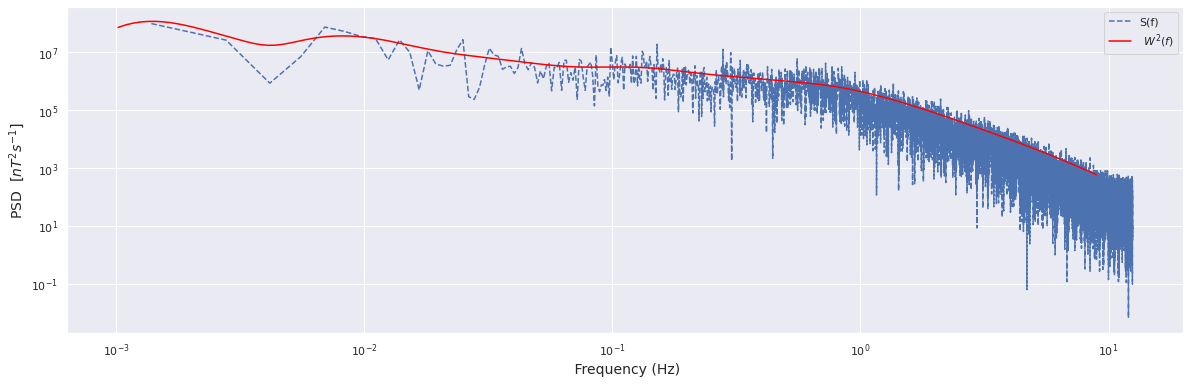

In [585]:
plt.figure(figsize=(20,6))
fourier_u = np.fft.fft(signalused)
freqs = np.fft.fftfreq(len(signalused),dt)
ii = freqs>0

freqs = freqs[ii]
#plt.plot(period,np.sum(power,axis=1)/len(signalused))
plt.plot(freqs, np.abs(fourier_u[ii])**2,linestyle="--",label="S(f)")
plt.plot(1/period,len(signalused)*global_ws,c="red",label=" $W^2(f)$")
plt.xlabel(" Frequency (Hz)",fontsize=14)
plt.ylabel("PSD  [$nT^2 s^{-1}$]",fontsize=14)
plt.yscale("log")
plt.xscale("log")
plt.legend()

Text(0, 0.5, 'PSD/s [$nT^2 s^{-2}$]')

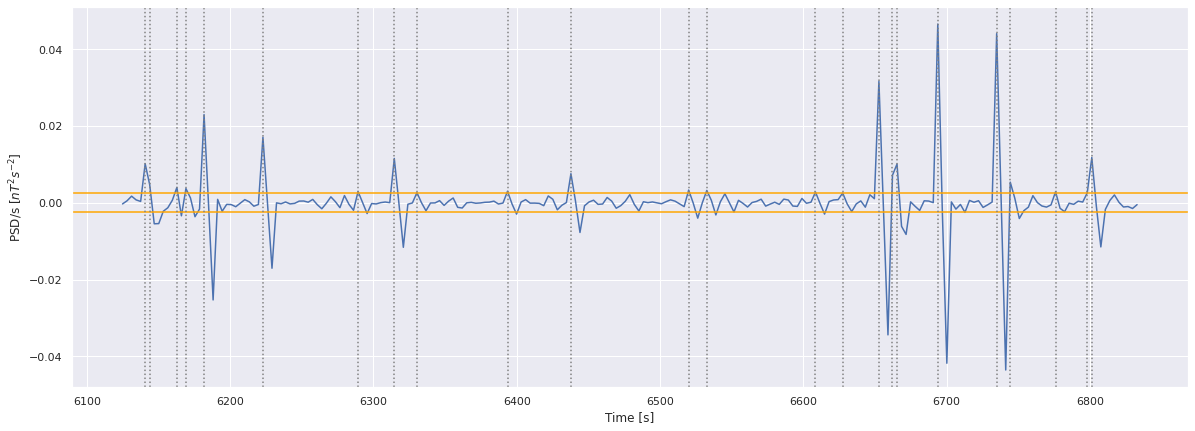

In [586]:
plt.figure(figsize=(20,7))
plt.plot(signal_t[0]+t[1:-1],dSt)
plt.axhline(slope_th,c="orange")
plt.axhline(-slope_th,c="orange")
for elem in range(len(peaks_time)) :
    plt.axvline(peaks_time[elem],linestyle=":",c="grey")
plt.xlabel("Time [s]")
plt.ylabel("PSD/s [$nT^2 s^{-2}$]")

In [587]:
slope_th


0.0025

In [588]:
len(signalused)*dt*resol

3.6001994096996324

In [589]:
sign_pieces = []
cols = ["Time [s]","Signal intensity [nT]","$\\theta$ [rad]","$\phi$ [rad]","piece index"]
df_pieces = pd.DataFrame(columns=cols)
pad_peaks_time = [signal_t[0]]+peaks_time+[signal_t[-1]]
for i in range(1,len(pad_peaks_time)):
    idx_piece = [j for j in range(len(signal_t)) if np.logical_and(signal_t[j]<=pad_peaks_time[i],signal_t[j]>pad_peaks_time[i-1])]
    sign_pieces.append(idx_piece)
    k_=[[np.take(signal_t,idx_piece)[h],np.take(signalused,idx_piece)[h],np.take(signal_theta,idx_piece)[h],np.take(signal_phi,idx_piece)[h],i] for h in range(len(idx_piece))]
    k_ = pd.DataFrame(k_,columns=cols)
    
    df_pieces=df_pieces.append(k_,ignore_index=True)
                       

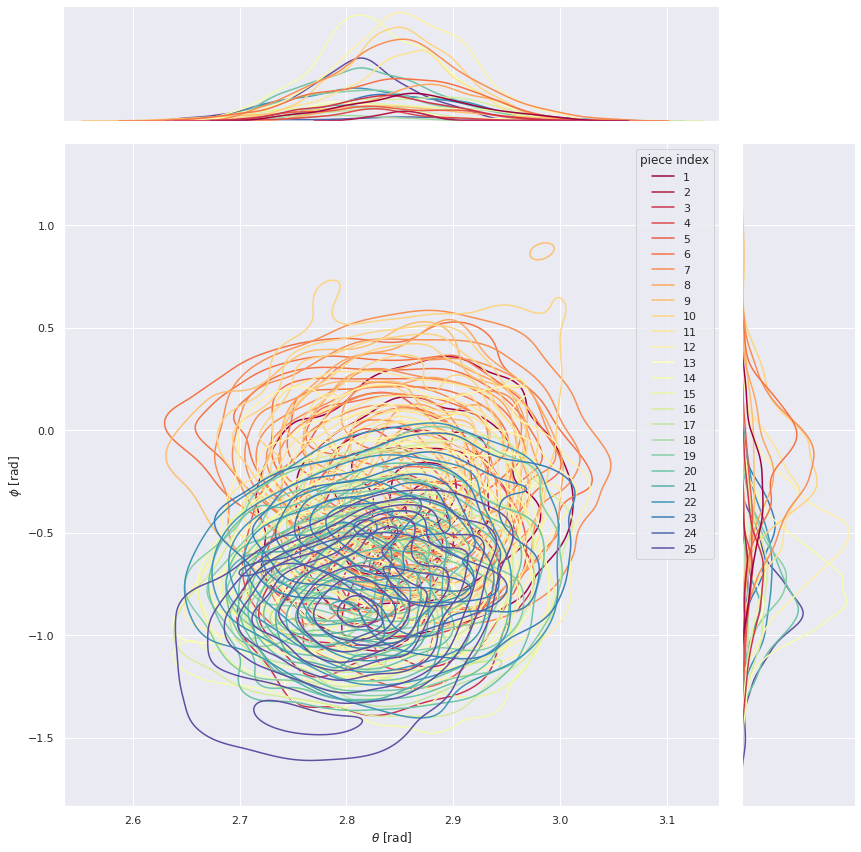

In [590]:
sns.set_theme(style="ticks")
sns.set(rc={'figure.figsize':(12,12)})


#plt.figure(figsize=(12,12))
# Show the joint distribution using kernel density estimation
sns.jointplot(data=df_pieces,height=12,x="$\\theta$ [rad]", y="$\phi$ [rad]", hue="piece index",kind="kde",palette="Spectral")

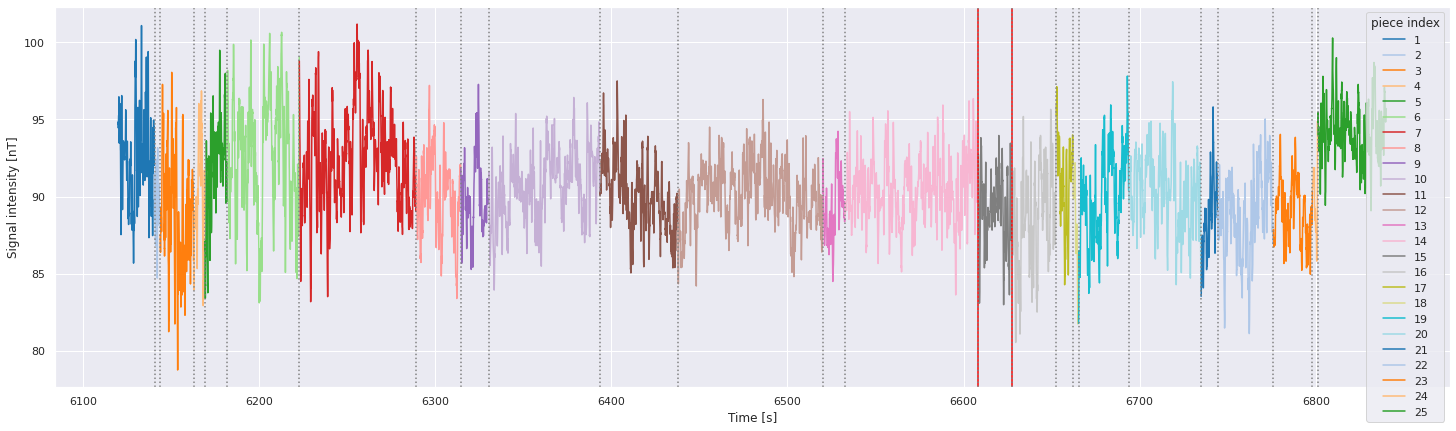

In [591]:
sns.set(rc={'figure.figsize':(25,7)})
sns.lineplot(data=df_pieces, x="Time [s]",y="Signal intensity [nT]",hue="piece index",palette="tab20",legend="full")
for elem in range(len(peaks_time)) :
    sel = 15
    if(elem in [sel-2,sel-1]):
        plt.axvline(peaks_time[elem],linestyle="-",c="red")
    plt.axvline(peaks_time[elem],linestyle=":",c="grey")


In [592]:
df_pieces[df_pieces.index.duplicated()]

Empty DataFrame
Columns: [Time [s], Signal intensity [nT], $\theta$ [rad], $\phi$ [rad], piece index]
Index: []

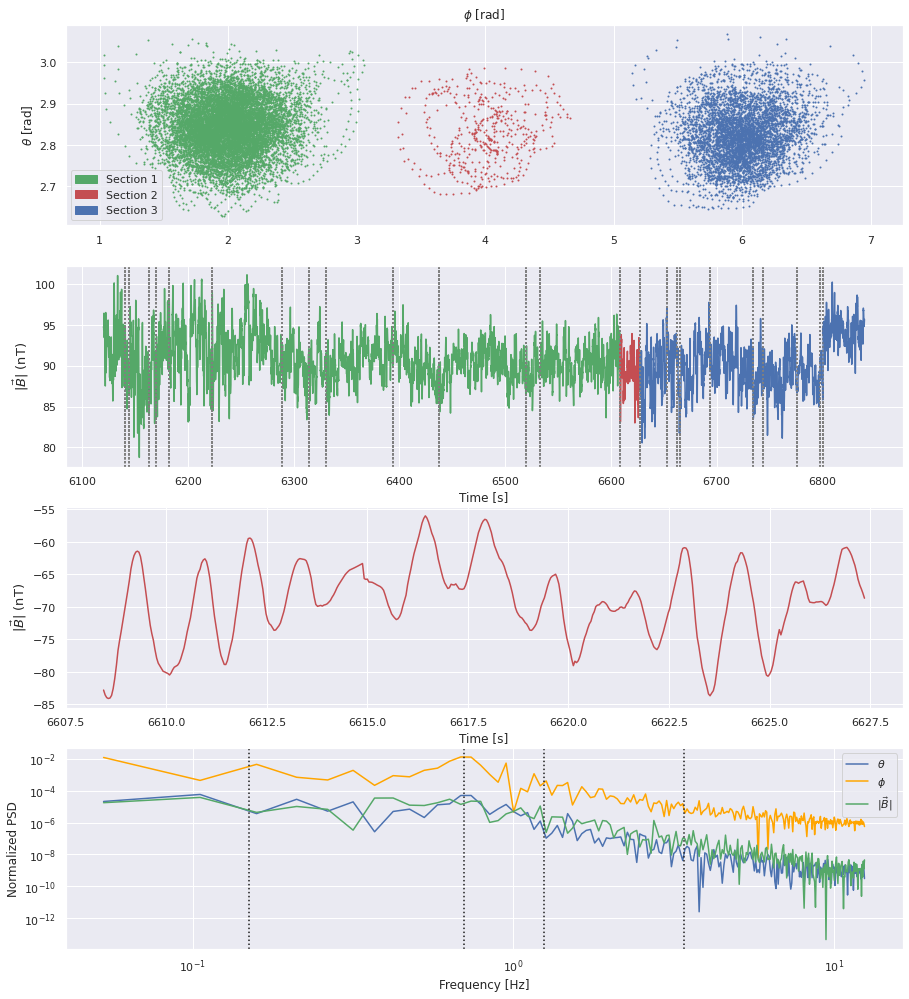

In [594]:
plt.figure(figsize=(15,17))
s_ = 1
x_reg = 14
region_bounds = [[0,14],[14,15],[15,len(sign_pieces)]]
region_cols =  ["g","r","b"]
region_list = np.zeros([len(sign_pieces)],int)
for i in range(len(region_bounds)):
    low_=region_bounds[i][0]
    high_=region_bounds[i][1]
    region_list[low_:high_:] = i
#region_=[ np.sum([np.array(region_bounds)<=i]) for i in range(sign_pieces)] 
cols = []
plt.subplot(4,1,1)
for i in range(len(sign_pieces)):
    plt.scatter(np.take(signal_phi,sign_pieces[i])+2+2*region_list[i]-np.mean(np.take(signal_phi,sign_pieces[i])),np.take(signal_theta,sign_pieces[i]),s=s_,c=region_cols[region_list[i]],label="{}".format(region_list[i]))
    #plt.plot(np.take(signal_phi,sign_pieces[i]),np.take(signal_theta,sign_pieces[i]),s=s_,c=np.arange(len(np.take(signal_theta,sign_pieces[i]))),cmap="jet")
ptch_ =[] 
for i in range(len(region_bounds)):
    ptch_.append(mpatches.Patch(color=region_cols[i], label="Section "+str(i+1)))
plt.legend(handles=ptch_)
plt.title("$\phi$ [rad]") 
plt.ylabel("$\\theta$ [rad]") 

plt.subplot(4,1,2)
for i in range(len(sign_pieces)):
    for elem in peaks_time :
        plt.axvline(elem,linestyle=":",c="grey")
    plt.plot(np.take(signal_t,sign_pieces[i]),np.take(signal_rho,sign_pieces[i]),c=region_cols[region_list[i]])
plt.xlabel("Time [s]") 
plt.ylabel('$|\\vec{B}|$ (nT)',fontsize=13)    
plt.subplot(4,1,3)
for i in range(len(sign_pieces)):
    if(region_list[i]!=1):
        continue
    
    plt.plot(np.take(signal_t,sign_pieces[i]),np.take(signal_x,sign_pieces[i])-np.mean(np.take(signal_rho,sign_pieces[i])),c=region_cols[region_list[i]])
plt.xlabel("Time [s]") 
plt.ylabel('$|\\vec{B}|$ (nT)',fontsize=13)
    
plt.subplot(4,1,4)



signal_region = np.concatenate([np.take(signal_theta,sign_pieces[j]) for j in range(len(sign_pieces)) if region_list[j]==1])
freqs_ = np.fft.fftfreq(len(signal_region),dt)
ii = freqs_>0 
freqs_ =freqs_[ii]
fourier_region = np.fft.fft(signal_region)[ii]/np.sum(signal_region)

plt.loglog(freqs_,(np.abs(fourier_region)**2),c="b",label="$\\theta$")



signal_region = np.concatenate([np.take(signal_phi,sign_pieces[j]) for j in range(len(sign_pieces)) if region_list[j]==1])
fourier_region = np.fft.fft(signal_region)[ii]/np.sum(signal_region)

plt.loglog(freqs_,(np.abs(fourier_region)**2),c="orange",label="$\phi$")




signal_region = np.concatenate([np.take(signal_rho,sign_pieces[j]) for j in range(len(sign_pieces)) if region_list[j]==1])
fourier_region = np.fft.fft(signal_region)[ii]/np.sum(signal_region)

plt.loglog(freqs_,(np.abs(fourier_region)**2),c="g",label="$|\\vec{B}|$")
plt.axvline(0.7,c="k",linestyle=":")
plt.axvline(3.4,c="k",linestyle=":")
#plt.axvline(1/16,c="k",linestyle=":")
plt.axvline(1.25,c="k",linestyle=":")
plt.axvline(0.15,c="k",linestyle=":")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized PSD")
plt.legend()

In [525]:
import

SyntaxError: invalid syntax (2125240012.py, line 1)

Text(0.5, 0, ' Frequency (Hz)')

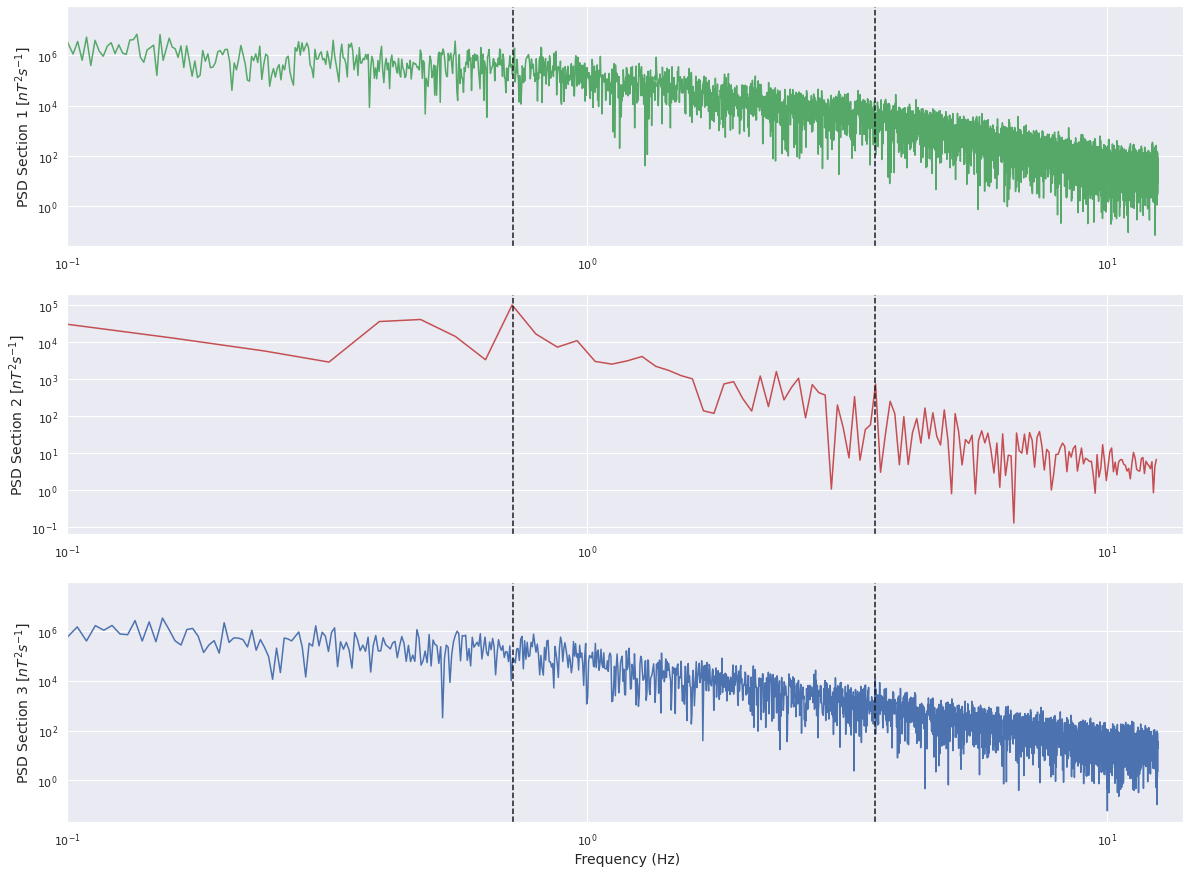

In [261]:
plt.figure(figsize=(20,15))
for i in range(len(region_bounds)):
    signal_region = np.concatenate([np.take(signalused,sign_pieces[j]) for j in range(len(sign_pieces)) if region_list[j]==i])
    freqs_ = np.fft.fftfreq(len(signal_region),dt)
    #ii = np.logical_and(freqs>=0,freqs<500)
    ii = freqs_>0 
    freqs_ =freqs_[ii]
    fourier_region = np.fft.fft(signal_region)[ii]
    
    plt.subplot(len(region_bounds),1,i+1)
    #plt.title("Fourier spectrum of Section {}".format(i+1))
    plt.loglog(freqs_,(np.abs(fourier_region)**2),c=region_cols[i])
    #plt.axvline(f[int(Sxx.shape[0]*thr)],c="g",linestyle="--")
    #plt.axvline(f[int(Sxx.shape[0]*thr)+delta],c="g",linestyle=":")
    #plt.axvline(f[int(Sxx.shape[0]*thr)-delta],c="g",linestyle=":")
    plt.axvline(0.72,c="k",linestyle="--")
    plt.axvline(3.57,c="k",linestyle="--")

    plt.xlim(1e-1,14)
    
    plt.ylabel("PSD Section "+str(i+1)+" [$nT^2 s^{-1}$]",fontsize=14)
plt.xlabel(" Frequency (Hz)",fontsize=14)
    

In [180]:
freqs_

array([4.35312626e-03, 8.70625252e-03, 1.30593788e-02, ...,
       1.24891192e+01, 1.24934724e+01, 1.24978255e+01])

In [33]:
np.concatenate(pieces)

NameError: name 'pieces' is not defined

In [549]:
#plt.plot(freqs[freqs<4],np.abs(fourier_m)**2)
#plt.yscale("log")
#plt.xscale("log")
freqs = np.fft.fftfreq(len(signal_phi),dt)
fft_u = np.fft.fft(signal_phi)

fft_u = fft_u[freqs>0]
freqs = freqs[freqs>0]



logPSD =np.log10(np.abs(fft_u)**2)
logf = np.log10(freqs)



def spec_func(x,a,b):
    return a*x+b
    
freq_cut = 0.5
ii1 = freqs<freq_cut
ii2 = freqs>=freq_cut

popt1,covt1 = curve_fit(spec_func,logf[ii1],logPSD[ii1])
popt2,covt2 = curve_fit(spec_func,logf[ii2],logPSD[ii2])
#popt2,covt2 = curve_fit(spec_func,np.log10(freqs[ii2]),np.log10(np.abs(fourier_m[ii2])**2))
print("Slope piece 1: ",popt1[0])
print("Slope piece 2: ",popt2[0])

Slope piece 1:  -1.4030476219428938
Slope piece 2:  -3.0945160815957378


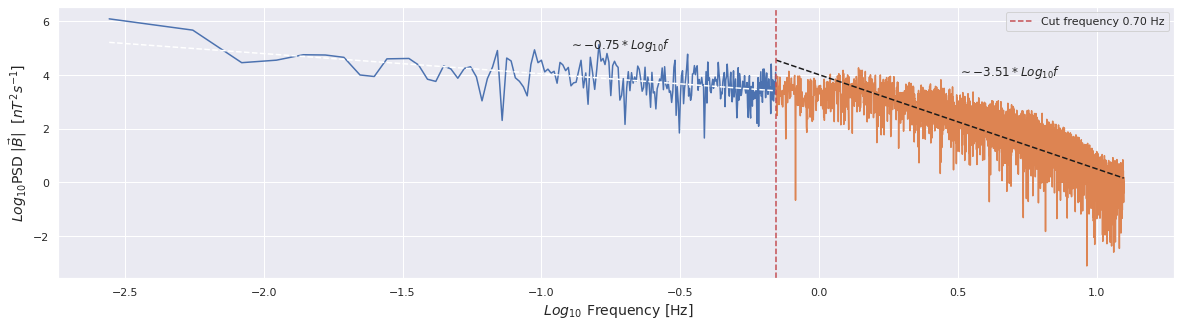

In [548]:
plt.figure(figsize=(20,5))
plt.plot(logf[ii1],logPSD[ii1])
plt.plot(logf[ii2],logPSD[ii2])
plt.plot(logf[ii1],spec_func(logf[ii1],*popt1),c="w",linestyle="--")
plt.plot(logf[ii2],spec_func(logf[ii2],*popt2),c="k",linestyle="--")
plt.text(-0.9,5,"$\sim { %.2f} * Log_{10}f$"%popt1[0])
plt.text(.5,4,"$\sim { %.2f} * Log_{10}f$"%popt2[0])
#plt.yscale("log")
plt.axvline(np.log10(freq_cut),c="r",linestyle="--",label="Cut frequency {:.2f} Hz".format(freq_cut))
#plt.xscale("log")
plt.ylabel("$Log_{10}$PSD $|\\vec{B}|$  $[nT^2 s^{-1}]$",fontsize=14)
plt.xlabel(" $Log_{10}$ Frequency [Hz]",fontsize=14)
plt.legend()

In [229]:
-5/3

-1.6666666666666667

In [ ]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 20
pi = np.pi
cos = np.cos
sin = np.sin


#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(sign_pieces)):
    #plt.scatter(np.take(signal_t,sign_pieces[i]),np.take(signalused,sign_pieces[i]),s=1,c=np.arange(len(np.take(signalused,sign_pieces[i]))),cmap="jet")
   
    phi = np.take(signal_phi,sign_pieces[i])-pi/2
    theta=np.take(signal_theta,sign_pieces[i])
    
    u, v = np.mgrid[0:2*np.pi:90j, 0:np.pi:90j]
    x = r*np.cos(u)*np.sin(v)
    y = r*np.sin(u)*np.sin(v)
    z = r*np.cos(v)
    ax.plot_wireframe(x, y, z, color="grey",alpha=0.01)
    
    
    #ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.6, linewidth=0)
    rr=0.8*r+r*i*0.2/len(sign_pieces)
    x = rr*sin(phi)*cos(theta)
    y = rr*sin(phi)*sin(theta)
    z = rr*cos(phi)
    
    ax.scatter(x,y,z,s=1,label=str(i+1))

ax.set_xlim([-r,r])
ax.set_ylim([-r,r])
ax.set_zlim([-r,r])
plt.tight_layout()
#plt.show()

In [282]:
n_vec = np.array([0.93, -0.26, 0.26])
l_vec = np.array([0.23, -0.13, -0.96])

m_vec = np.cross(l_vec,n_vec)



array([-0.2834, -0.9526,  0.0611])

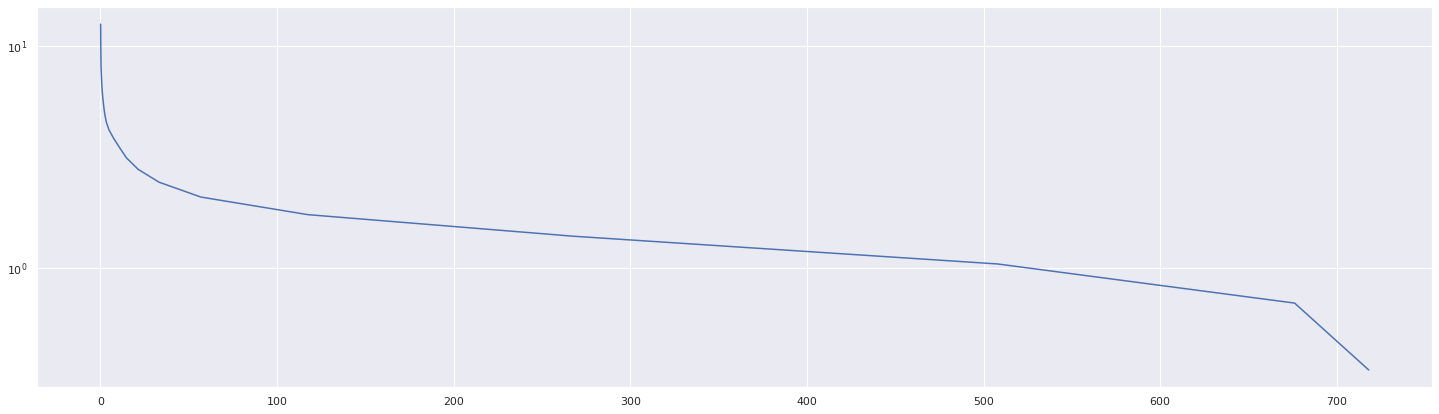

In [387]:
plt.plot(Sx[1:],f[1:])
plt.yscale("log")
#plt.xscale("log")

In [ ]:
from scipy.optimize import curve_fit

def ftrend(x,a,b,c,d):
    return a * np.exp(b*x) +x* c*np.exp(d*x) 

popt,var = curve_fit(ftrend,f[1:],Sx[1:])
yopt = ftrend(f[1:],*popt)

NameError: name 'yopt' is not defined

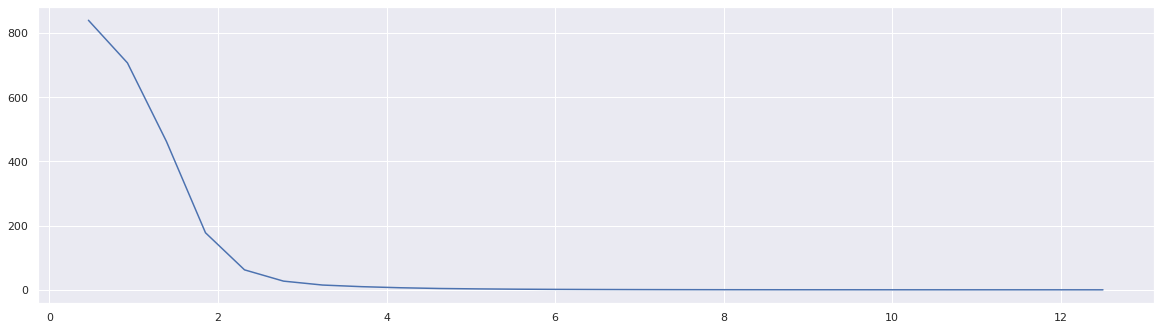

In [319]:
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(f[1:],Sx[1:])
plt.plot(f[1:],yopt)
plt.yscale("log")

plt.xscale("log")

plt.subplot(2,1,2)
plt.plot(f[1:],np.abs(Sx[1:]-yopt))
plt.yscale("log")

plt.xscale("log")

In [ ]:
popt

In [ ]:
np.min(Sxx)